In [1]:
# https://deeplearningcourses.com/c/deep-learning-advanced-nlp
from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future

import os
import sys

from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding, \
  Bidirectional, RepeatVector, Concatenate, Activation, Dot, Lambda
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras.backend as K

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [3]:
# make sure we do softmax over the time axis
# expected shape is N x T x D
# note: the latest version of Keras allows you to pass in axis arg
def softmax_over_time(x):
    assert(K.ndim(x) > 2)
    e = K.exp(x - K.max(x, axis=1, keepdims=True))
    s = K.sum(e, axis=1, keepdims=True)
    return e / s

In [77]:
# config
BATCH_SIZE = 64
EPOCHS = 100
LATENT_DIM = 256
LATENT_DIM_DECODER = 256  # idea: make it different to ensure things all fit together properly!
NUM_SAMPLES = 10000
MAX_SEQUENCE_LENGTH = 100
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100

# Where we will store the data
input_texts = []  # sentence in original language
target_texts = []  # sentence in target language
target_texts_inputs = []  # sentence in target language offset by 1

In [73]:
# load in the data
# download the data at: http://www.manythings.org/anki/
text_path = r"C:\Users\Hiroshi\PycharmProjects\machine_learning_examples\large_files\translation\\"
t = 0
for line in open(text_path + 'spa.txt', encoding="utf-8"):
    # only keep a limited number of samples
    t += 1
    if t > NUM_SAMPLES:
        break

    # input and target are separated by tab
    if '\t' not in line:
        continue

    # split up the input and translation
    input_text, translation = line.rstrip().split('\t')[:2]

    # make the target input and output
    # recall we'll be using teacher forcing
    target_text = translation + ' <eos>'
    target_text_input = '<sos> ' + translation

    input_texts.append(input_text)
    target_texts.append(target_text)
    target_texts_inputs.append(target_text_input)
print("num samples:", len(input_texts))

num samples: 1000


In [13]:
# English
input_texts[-10:]

['When did it end?',
 'When do you run?',
 'Where can we go?',
 'Where did he go?',
 'Where is Boston?',
 'Where is my car?',
 'Where is my car?',
 "Where's Tom now?",
 "Where's my book?",
 "Where's my cane?"]

In [14]:
# Spanish
target_texts[-10:]

['¿Cuándo terminó? <eos>',
 '¿Cuándo correrás? <eos>',
 '¿Adónde podemos ir? <eos>',
 '¿A dónde fue él? <eos>',
 '¿Dónde está Boston? <eos>',
 '¿Dónde está mi coche? <eos>',
 '¿Dónde está mi auto? <eos>',
 '¿Dónde está Tom ahora? <eos>',
 '¿Dónde está mi libro? <eos>',
 '¿Dónde está mi bastón? <eos>']

In [15]:
# tokenize the inputs
tokenizer_inputs = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

# get the word to index mapping for input language
word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.' % len(word2idx_inputs))

# determine maximum length input sequence
max_len_input = max(len(s) for s in input_sequences)

# tokenize the outputs
# don't filter out special characters
# otherwise <sos> and <eos> won't appear
tokenizer_outputs = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs)  # inefficient, oh well
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

# get the word to index mapping for output language
word2idx_outputs = tokenizer_outputs.word_index
print('Found %s unique output tokens.' % len(word2idx_outputs))

Found 2352 unique input tokens.
Found 6325 unique output tokens.


In [34]:
# English word index
result = {k:word2idx_inputs[k] for k in list(word2idx_inputs)[:10]}
print(result)

{'i': 1, 'tom': 2, 'is': 3, 'you': 4, 'it': 5, 'a': 6, "i'm": 7, 'me': 8, 'he': 9, 'this': 10}


In [35]:
# Spanish word index
result = {k:word2idx_outputs[k] for k in list(word2idx_outputs)[:10]}
print(result)

{'<eos>': 1, '<sos>': 2, 'es': 3, 'tom': 4, 'a': 5, 'no': 6, 'me': 7, 'un': 8, 'está': 9, 'lo': 10}


In [36]:
# store number of output words for later
# remember to add 1 since indexing starts at 1
num_words_output = len(word2idx_outputs) + 1

# determine maximum length output sequence
max_len_target = max(len(s) for s in target_sequences)
# pad the sequences
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print("encoder_data.shape:", encoder_inputs.shape)
print("encoder_data[0]:", encoder_inputs[0])

decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post')  # why post?
print("decoder_data[0]:", decoder_inputs[0])
print("decoder_data.shape:", decoder_inputs.shape)

decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')

encoder_data.shape: (10000, 5)
encoder_data[0]: [ 0  0  0  0 13]
decoder_data[0]: [   2 1464    0    0    0    0    0    0    0]
decoder_data.shape: (10000, 9)


In [43]:
# store all the pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('../large_files/glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM), encoding="utf-8") as f:
    # is just a space-separated text file in the format:
    # word vec[0] vec[1] vec[2] ...
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [53]:
print("dimension of vectors")
print(word2vec["the"].shape)
word2vec["the"]

dimension of vectors
(100,)


array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
       -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
        0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
       -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
        0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
       -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
        0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
        0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
       -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
       -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
       -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
       -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
       -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
       -1.2526  ,  0.071624,  0.70565 ,  0.49744 , 

In [54]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx_inputs.items():
    if i < MAX_NUM_WORDS:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all zeros.
            embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [57]:
embedding_matrix.shape

(2353, 100)

In [58]:
# create embedding layer
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=max_len_input,
  # trainable=True
)

In [59]:
embedding_layer

In [60]:
max_len_input

5

In [61]:
# create targets, since we cannot use sparse
# categorical cross entropy when we have sequences
decoder_targets_one_hot = np.zeros(
  (
    len(input_texts),
    max_len_target,
    num_words_output
  ),
  dtype='float32'
)

# assign the values
for i, d in enumerate(decoder_targets):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1

In [62]:
"""
build the model
"""

# Set up the encoder - simple!
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = Bidirectional(LSTM(
  LATENT_DIM,
  return_sequences=True,
  # dropout=0.5 # dropout not available on gpu
))
encoder_outputs = encoder(x)


# Set up the decoder - not so simple
decoder_inputs_placeholder = Input(shape=(max_len_target,))

# this word embedding will not use pre-trained vectors
# although you could
decoder_embedding = Embedding(num_words_output, EMBEDDING_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

In [ ]:
"""
Attention
"""
# Attention layers need to be global because
# they will be repeated Ty times at the decoder
attn_repeat_layer = RepeatVector(max_len_input)
attn_concat_layer = Concatenate(axis=-1)
attn_dense1 = Dense(10, activation='tanh')
attn_dense2 = Dense(1, activation=softmax_over_time)
attn_dot = Dot(axes=1)  # to perform the weighted sum of alpha[t] * h[t]


def one_step_attention(h, st_1):
    # h = h(1), ..., h(Tx), shape = (Tx, LATENT_DIM * 2)
    # st_1 = s(t-1), shape = (LATENT_DIM_DECODER,)
 
    # copy s(t-1) Tx times
    # now shape = (Tx, LATENT_DIM_DECODER)
    st_1 = attn_repeat_layer(st_1)

    # Concatenate all h(t)'s with s(t-1)
    # Now of shape (Tx, LATENT_DIM_DECODER + LATENT_DIM * 2)
    x = attn_concat_layer([h, st_1])

    # Neural net first layer
    x = attn_dense1(x)

    # Neural net second layer with special softmax over time
    alphas = attn_dense2(x)

    # "Dot" the alphas and the h's
    # Remember a.dot(b) = sum over a[t] * b[t]
    context = attn_dot([alphas, h])

    return context


# define the rest of the decoder (after attention)
decoder_lstm = LSTM(LATENT_DIM_DECODER, return_state=True)
decoder_dense = Dense(num_words_output, activation='softmax')

initial_s = Input(shape=(LATENT_DIM_DECODER,), name='s0')
initial_c = Input(shape=(LATENT_DIM_DECODER,), name='c0')
context_last_word_concat_layer = Concatenate(axis=2)


# Unlike previous seq2seq, we cannot get the output
# all in one step
# Instead we need to do Ty steps
# And in each of those steps, we need to consider
# all Tx h's

# s, c will be re-assigned in each iteration of the loop
s = initial_s
c = initial_c

# collect outputs in a list at first
outputs = []
for t in range(max_len_target):  # Ty times
    # get the context using attention
    context = one_step_attention(encoder_outputs, s)

    # we need a different layer for each time step
    selector = Lambda(lambda x: x[:, t:t+1])
    xt = selector(decoder_inputs_x)
  
    # combine
    decoder_lstm_input = context_last_word_concat_layer([context, xt])

    # pass the combined [context, last word] into the LSTM
    # along with [s, c]
    # get the new [s, c] and output
    o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[s, c])

    # final dense layer to get next word prediction
    decoder_outputs = decoder_dense(o)
    outputs.append(decoder_outputs)


# 'outputs' is now a list of length Ty
# each element is of shape (batch size, output vocab size)
# therefore if we simply stack all the outputs into 1 tensor
# it would be of shape T x N x D
# we would like it to be of shape N x T x D

def stack_and_transpose(x):
    # x is a list of length T, each element is a batch_size x output_vocab_size tensor
    x = K.stack(x) # is now T x batch_size x output_vocab_size tensor
    x = K.permute_dimensions(x, pattern=(1, 0, 2)) # is now batch_size x T x output_vocab_size
    return x


# make it a layer
stacker = Lambda(stack_and_transpose)
outputs = stacker(outputs)

# create the model
model = Model(
  inputs=[
    encoder_inputs_placeholder,
    decoder_inputs_placeholder,
    initial_s, 
    initial_c,
  ],
  outputs=outputs
)


def custom_loss(y_true, y_pred):
    # both are of shape N x T x K
    mask = K.cast(y_true > 0, dtype='float32')
    out = mask * y_true * K.log(y_pred)
    return -K.sum(out) / K.sum(mask)


def acc(y_true, y_pred):
    # both are of shape N x T x K
    targ = K.argmax(y_true, axis=-1)
    pred = K.argmax(y_pred, axis=-1)
    correct = K.cast(K.equal(targ, pred), dtype='float32')

    # 0 is padding, don't include those
    mask = K.cast(K.greater(targ, 0), dtype='float32')
    n_correct = K.sum(mask * correct)
    n_total = K.sum(mask)
    return n_correct / n_total


# compile the model
model.compile(optimizer='adam', loss=custom_loss, metrics=[acc])
# model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

# train the model
z = np.zeros((len(encoder_inputs), LATENT_DIM_DECODER)) # initial [s, c]
r = model.fit(
  [encoder_inputs, decoder_inputs, z, z], decoder_targets_one_hot,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=0.2
)

C:\Users\Hiroshi\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 56s 7ms/step - loss: 3.0473 - acc: 0.1175 - val_loss: 2.7502 - val_acc: 0.2543
Epoch 2/100
8000/8000 [==============================] - 42s 5ms/step - loss: 2.0956 - acc: 0.3004 - val_loss: 2.4972 - val_acc: 0.2898
Epoch 3/100
8000/8000 [==============================] - 42s 5ms/step - loss: 1.8576 - acc: 0.3398 - val_loss: 2.3422 - val_acc: 0.3229
Epoch 4/100
8000/8000 [==============================] - 42s 5ms/step - loss: 1.6681 - acc: 0.3772 - val_loss: 2.2347 - val_acc: 0.3545
Epoch 5/100
8000/8000 [==============================] - 41s 5ms/step - loss: 1.5051 - acc: 0.4217 - val_loss: 2.1549 - val_acc: 0.3779
Epoch 6/100
8000/8000 [==============================] - 44s 6ms/step - loss: 1.3645 - acc: 0.4539 - val_loss: 2.1231 - val_acc: 0.3997
Epoch 7/100
3200/8000 [===========>..................] - ETA: 24s - loss: 1.2500 - acc: 0.4780

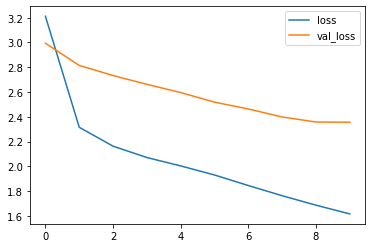

In [65]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

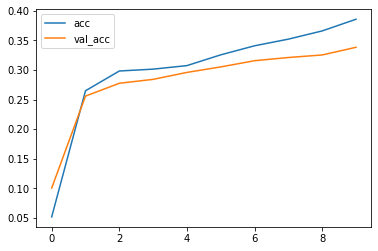

In [66]:
# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [67]:
"""
Make Predictions
"""

# As with the poetry example, we need to create another model
# that can take in the RNN state and previous word as input
# and accept a T=1 sequence.

# The encoder will be stand-alone
# From this we will get our initial decoder hidden state
# i.e. h(1), ..., h(Tx)
encoder_model = Model(encoder_inputs_placeholder, encoder_outputs)

# next we define a T=1 decoder model
encoder_outputs_as_input = Input(shape=(max_len_input, LATENT_DIM * 2,))
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

# no need to loop over attention steps this time because there is only one step
context = one_step_attention(encoder_outputs_as_input, initial_s)

# combine context with last word
decoder_lstm_input = context_last_word_concat_layer([context, decoder_inputs_single_x])


# lstm and final dense
o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[initial_s, initial_c])
decoder_outputs = decoder_dense(o)


# note: we don't really need the final stack and tranpose
# because there's only 1 output
# it is already of size N x D
# no need to make it 1 x N x D --> N x 1 x D


# create the model object
decoder_model = Model(
  inputs=[
    decoder_inputs_single,
    encoder_outputs_as_input,
    initial_s, 
    initial_c
  ],
  outputs=[decoder_outputs, s, c]
)


# map indexes back into real words
# so we can view the results
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    enc_out = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))
  
    # Populate the first character of target sequence with the start character.
    # NOTE: tokenizer lower-cases all words
    target_seq[0, 0] = word2idx_outputs['<sos>']

    # if we get this we break
    eos = word2idx_outputs['<eos>']

    # [s, c] will be updated in each loop iteration
    s = np.zeros((1, LATENT_DIM_DECODER))
    c = np.zeros((1, LATENT_DIM_DECODER))

    # Create the translation
    output_sentence = []
    for _ in range(max_len_target):
        o, s, c = decoder_model.predict([target_seq, enc_out, s, c])

        # Get next word
        idx = np.argmax(o.flatten())

        # End sentence of EOS
        if eos == idx:
            break

        word = ''
        if idx > 0:
            word = idx2word_trans[idx]
            output_sentence.append(word)

        # Update the decoder input
        # which is just the word just generated
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)

In [76]:
while True:
    # Do some test translations
    i = np.random.choice(len(input_texts))
    input_seq = encoder_inputs[i:i+1]
    translation = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[i])
    print('Predicted translation:', translation)
    print('Actual translation:', target_texts[i])

    ans = input("Continue? [Y/n]")
    if ans and ans.lower().startswith('n'):
        break

-
Input sentence: I'm dying.
Predicted translation: estoy muy
Actual translation: Me estoy muriendo. <eos>


Continue? [Y/n] y


-
Input sentence: I'm thin.
Predicted translation: soy bien.
Actual translation: Soy delgado. <eos>


Continue? [Y/n] y


-
Input sentence: Take care.
Predicted translation: ellos no se se se se los sí.
Actual translation: Cuídate. <eos>


Continue? [Y/n] y


-
Input sentence: Wait here.
Predicted translation: ¿puedo de mí.
Actual translation: Esperen aquí. <eos>


Continue? [Y/n] n
